In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from Functions import *

In [2]:
c = 3*1e8
ng_1550     = 1.595643967049753
freq_1550   = c/(1550*1e-9)


In [3]:
def Control_angle_range_0_2_2pi(angle):
    mask_less = np.where(angle < 0)
    mask_more = np.where(angle > 2*np.pi)
    angle_copy = np.copy(angle)
    angle_copy[mask_less] = angle[mask_less] + (np.astype(-angle[mask_less] / (2*np.pi),int)+1) *2*np.pi
    angle_copy[mask_more] = angle[mask_more] - (np.astype(angle[mask_more] / (2*np.pi),int)) *2*np.pi
    return angle_copy


In [4]:
def Control_angle_range_mpi_2_pi(angle):
    mask_less = np.where(angle < - np.pi)
    mask_more = np.where(angle > np.pi)
    angle_copy = np.copy(angle)
    angle_copy[mask_less] = angle[mask_less] + (np.astype((-angle[mask_less]+np.pi)/ (2*np.pi),int)) *2*np.pi
    angle_copy[mask_more] = angle[mask_more] - (np.astype((angle[mask_more]+np.pi) / (2*np.pi),int)) *2*np.pi
    return angle_copy


In [5]:
def Interpolation(x,y,x_intp,num_of_pts=100):
    cs = CubicSpline(x, y, bc_type='natural')  # bc_type 可选 'natural', 'clamped', 'periodic' 等
    y_intp = cs(x_intp)
    return y_intp


In [6]:
def Eigenvalue_arg(freq,g,Lco,LAS,LAL,LBS,LBL,include_theory=False):
    LA      = 2*(LAS + LAL + Lco)     # unit: m
    LB      = 2*(LBS + LBL + Lco)     # unit: m
    beta    = ng_1550/c * freq * 2*np.pi         # unit: /m
    Sum     = np.exp(2* 1j * beta * LAS) + np.exp(2* 1j * beta * LBL)
    Diff    = np.exp(2* 1j * beta * LAS) - np.exp(2* 1j * beta * LBL)
    # print(beta)
    # print("Sum = ", np.angle(Sum)[:10])
    # print("Sum_theory = ", np.angle(np.exp(1j *2 * beta[:10] * LAS)))
    # print("Diff = ", Diff)
    # print(g)

    DL_uco  = (LBL-LAS)
    DL_tot  = (LB-LA)/2
    DL      = DL_uco - DL_tot
    F       = Sum * np.cos(2 * g * Lco) * np.cos(beta * DL) - 1j * Diff * np.sin(beta * DL)

    Ang_offset  = - np.angle(np.exp(1j * beta * (LAS+LBL)))
    Ang_p       = Control_angle_range_0_2_2pi(np.angle(0.5*(F + 1j * np.sqrt((Sum**2-Diff**2) - F**2))) + Ang_offset) - np.pi
    Ang_m       = Control_angle_range_0_2_2pi(np.angle(0.5*(F - 1j * np.sqrt((Sum**2-Diff**2) - F**2))) + Ang_offset) - np.pi

    flip_mask   = np.where(Ang_p < Ang_m)
    Ang_pre                 = np.c_[Ang_p, Ang_m]
    Ang_pre[flip_mask]      = np.flip(Ang_pre[flip_mask],axis=1)
    if include_theory:
        Ang_pre             = np.c_[Ang_pre,Ang_theory_p,Ang_theory_m]
    return Ang_pre

In [7]:
# Load kappa under different wavls of two coupled WGs width 2.8um
def Load_kappa_data():
    c = 3*1e8
    Kappa_arr = []
    with open ("./results/straight_WG_Kappa.txt",'r') as f:
        read_data = f.readlines()
        for line in read_data[1:]:
            line_strip = line.strip()
            wavl = float(line_strip.split(",")[0])
            freq = c/wavl * 1e9
            K_12 = str2complex(line_strip.split(",")[1])
            K_21 = str2complex(line_strip.split(",")[2])
            Kappa = (K_12+K_21)/2
            Kappa = np.real(Kappa)
            Kappa_arr.append([freq,Kappa])
        Kappa_arr = np.array(Kappa_arr)
    return Kappa_arr

In [8]:
# g : dict of coupling strength
def Reson_freq_2D(m,D_ave,g,L,epsilon):
    return D_ave/(2*np.pi)*np.arccos(np.cos(g*L)*np.cos(2*np.pi * epsilon *m))

def FSR_func_2D(m,D_ave,g,L,epsilon):
    return epsilon * D_ave/(2*np.pi)* np.cos(g*L)*np.sin(2*np.pi * epsilon *m) /        \
            (1-np.cos(g*L)**2 * np.cos(2*np.pi * epsilon *m)**2)**0.5

def Dispersion_2D(m,D_ave,g,L,epsilon):
    return D_ave * 2*np.pi* epsilon**2 *np.cos(g*L) *np.sin(g*L)**2 * np.cos(2*np.pi*epsilon*m) / \
            (1-np.cos(g*L)**2 * np.cos(2*np.pi * epsilon *m)**2)**1.5

def Dispersion_2D_num(m,reson_freq):
    FSR = First_derivative_central_diff(reson_freq,m)
    return First_derivative_central_diff(FSR,m[1:-1])

In [9]:
def Reson_freq_3D_numerical(m,D_ave,g,Lco,LAS,LAL,LBS,LBL):
    LA = 2*(Lco+LAS+LAL)
    LB = 2*(Lco+LBS+LBL)
    L_ave = (LA+LB)/2
    freq = m*c/(ng_1550*L_ave)
    # freq = freq_1550 + m * D_ave/(2*np.pi)
    Eigenvalue_Arg  = Eigenvalue_arg(freq,g,Lco,LAS,LAL,LBS,LBL)
    return D_ave/(2*np.pi) * Eigenvalue_Arg

def Reson_freq_3D(m_arr_intp,D_ave,g,Lco,LAS,LAL,LBS,LBL):
    LA      = 2*(LAS + LAL + Lco)     # unit: m
    LB      = 2*(LBS + LBL + Lco)     # unit: m
    L_ave   = (LA+LB)/2
    DL_uc1  = (LBL-LAS)
    DL_uc2  = (LBS-LAL)
    return D_ave/(2*np.pi)*np.arccos( np.cos(2*np.pi * DL_uc1 * m_arr_intp/ L_ave) * np.cos(2*np.pi * DL_uc2 * m_arr_intp/ L_ave)\
            * np.cos(2*g*Lco) - np.sin(2*np.pi * DL_uc1 * m_arr_intp/ L_ave) * np.sin(2*np.pi * DL_uc2 * m_arr_intp/ L_ave) )

def FSR_func_3D(m,reson_freq):
    FSR = First_derivative_central_diff(reson_freq,m)
    return FSR

def Dispersion_3D(m,reson_freq):
    FSR = FSR_func_3D(m,reson_freq)
    return First_derivative_central_diff(FSR,m[1:-1])

def TOD_3D(m,reson_freq):
    GVD = Dispersion_3D(m,reson_freq)
    return First_derivative_central_diff(GVD,m[2:-2])

In [10]:
# returns the anomalous dispersion range around 1550nm of 2D parallel coupled rings (unit: nm)
def AD_range_func(m_arr,D_arr,M,FSR):
    zero_list,zero_idx_list = find_zero(m_arr, D_arr)
    zero_list               = np.array(zero_list)
    zero_list_m_0           = zero_list[np.where(np.abs(zero_list) < M)]      # zeros around mode numer m = 0
    zero_list_m_0_p         = zero_list_m_0[zero_list_m_0>0]
    zero_list_m_0_m         = zero_list_m_0[zero_list_m_0<0]
    if len(zero_list_m_0_p) > 0 and  len(zero_list_m_0_m) > 0  and D_arr[np.argmin(np.abs(m_arr))] > 0:
        return (np.min(zero_list_m_0_p) - np.max(zero_list_m_0_m))*FSR * 1e-9 /100 * 0.8
    else:
        return 0

In [11]:
def epsilon_func(L1,L2):
    return (L2-L1)/(L1+L2)

In [12]:
def Mode_nonconserved_coupling(Max_M_idx,M,
                               plot_coupled_curves=True,
                               coupled_data_arr=[],coupled_data_label_arr=[],
                               param_dict_={},
                               title = "Mode number non-conservation coupling",
                               num_of_pts=100,ylim=()):
    m_arr = np.linspace(-Max_M_idx*M, Max_M_idx*M, num_of_pts).reshape(-1,1)
    M0 = 0
    Y_legends = []
    Y_data = np.array(D1 * (m_arr - M0))
    Y_legends.append(r"Resonator1 $\omega = \omega_0$+$(D_1-D_{ave})$(m-$M_0$)")
    for m in range(1,Max_M_idx):
        Y = D1 * (m_arr - M0) + m*FSR
        Y_data = np.c_[Y_data,Y]
        Y_legends.append(r"Resonator1 $\omega$ = $\omega_0$+$(D_1-D_{ave})$(m-$M_0$)$\pm$"+str(m)+r"$D_{ave}$")
        Y = D1 * (m_arr - M0) - m*FSR
        Y_data = np.c_[Y_data,Y]
        Y_legends.append("")

    Y = D2 * (m_arr - M0)
    Y_data = np.c_[Y_data,Y]
    Y_legends.append(r"Resonator2 $\omega = \omega_0$+$(D_2-D_{ave})$(m-$M_0$)")
    for m in range(1,Max_M_idx):
        Y = D2 * (m_arr - M0) +  m*FSR
        Y_data = np.c_[Y_data,Y]
        Y_legends.append(r"Resonator2 $\omega$ = $\omega_0$+$(D_2-D_{ave})$(m-$M_0$)$\pm$"+str(m)+r"$D_{ave}$")
        Y = D2 * (m_arr - M0) -  m*FSR
        Y_data = np.c_[Y_data,Y]
        Y_legends.append("")
    Y_data = Y_data - D_ave * (m_arr - M0)

    if plot_coupled_curves:
        Y_data = np.c_[Y_data,coupled_data_arr]
        Y_legends = Y_legends + coupled_data_label_arr

    linestyle_name_list = ["dashed","dotted"]*3
    linestyle_list      = ["-"]
    for i in range(Max_M_idx-1):
        for j in range(2):
            linestyle_list.append(linestyle_name_list[i])
    linestyle_list = linestyle_list + linestyle_list
    linestyle_list = linestyle_list + ["-"]*30
    colors_list = ['lightskyblue']*(Max_M_idx*2-1)+ ['lightcoral']*(Max_M_idx*2-1)\
                    +['orange']*2+['dodgerblue']*2+['black']*30

    xticks       = np.arange(-Max_M_idx,Max_M_idx+1)
    xtickslabels = [("$M_0$+" if xtick>0 else "$M_0$") + str(xtick) + "M"  for xtick in xticks]
    xtickslabels[int(len(xtickslabels)/2)] = "$M_0$"
    xticks       = np.arange(-Max_M_idx,Max_M_idx+1)*M

    param_dict = {  "Y_legends"       : Y_legends,
                    "X_label"         : 'mode number m',
                    "Y_label"         : r"Frequency $\omega$/(2$\pi$) (GHz)",
                    "xticks"          : xticks,
                    "xtickslabel"     : xtickslabels,
                    "title"           : title,
                    "marker_list"     : [""]*30,
                    "linestyle_list"  : linestyle_list,
                    "colors_list"     : colors_list,
                    "xlim"            : (-Max_M_idx*M,Max_M_idx*M),
                    "ylim"            : ylim,
                    "bbox_legend"     : (1.05,0.8)}
    if len(param_dict_)>0:
        for key,value in param_dict_.items():
            param_dict[key] = value

    data_arr = (np.c_[m_arr,Y_data/1e9/(2*np.pi)],)

    Plot_curve(data_arr,**param_dict)

In [13]:
Max_M_idx   = 3
num_of_pts  = 10000

In [14]:
# unit: m
#Ruc = 1.01
#Ruc = 1.0054
Ruc = 1.0122

Rtot= 1.005
Lco = 1.11   * 1e-3
LAS = 3.14  * 1e-3
LAL = LAS   * Ruc
LBS = LAS   * Rtot + Lco * (Rtot-1) / (1+Ruc)
LBL = LBS   * Ruc

g0  = 675
# Lco = 0.8 / g0
print("LBS=",LBS)
print("LAL=",LAL)

LBS= 0.0031584581751316963
LAL= 0.003178308


In [15]:
L1      = (Lco + LAS + LAL)*2
L2      = (Lco + LBS + LBL)*2
D1      = c/(ng_1550 * L1) *2* np.pi
D2      = c/(ng_1550 * L2) *2* np.pi
D_ave   = c/(ng_1550 * (L1+L2)/2) *2 *np.pi
epsilon = (L2-L1)/(L1+L2)
FSR     = (D1-D2)/(2*epsilon)
M       = 1/(2*epsilon)

FSR/1e9/(2*np.pi)
D_ave/(2*np.pi*1e9)
print("M=",M)
print("D_ave/2pi=",D_ave/(2*np.pi*1e9))
print("epsilon=",epsilon)


M= 200.50000000000182
D_ave/2pi= 12.62353477103581
epsilon= 0.00249376558603489


In [16]:
Kappa_arr       = Load_kappa_data()
Kappa_arr       = np.flip(Kappa_arr,axis=0)
freq_arr        = Kappa_arr[:,0]
freq_arr

array([1.85185185e+14, 1.86335404e+14, 1.87500000e+14, 1.88679245e+14,
       1.89873418e+14, 1.91082803e+14, 1.92307692e+14, 1.93548387e+14,
       1.94805195e+14, 1.96078431e+14, 1.97368421e+14, 1.98675497e+14,
       2.00000000e+14, 2.01342282e+14, 2.02702703e+14])

In [17]:
m_arr_intp      = np.linspace(-Max_M_idx*M, Max_M_idx*M, num_of_pts)
freq_arr_intp   = freq_1550 + m_arr_intp * D_ave/(2*np.pi)
g_arr_intp      = Interpolation(freq_arr,Kappa_arr[:,1],freq_arr_intp)
data_arr        = np.c_[m_arr_intp,freq_arr_intp,g_arr_intp]

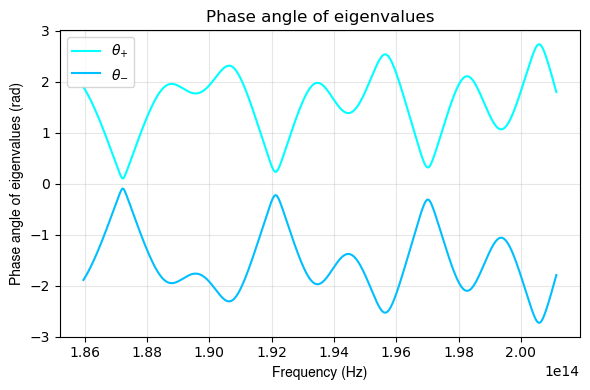

In [18]:
Eigenvalue_Arg = Eigenvalue_arg(freq_arr_intp,g_arr_intp,Lco,LAS,LAL,LBS,LBL)
data_arr        = (np.c_[freq_arr_intp,Eigenvalue_Arg],)
data_label_arr  = [r"$\theta_{+}$",r"$\theta_{-}$",r"$\theta_{theory,+}$",r"$\theta_{theory,+}$"]*3
linestyle_list  = ["-","-","--","--"]*3
colors_list     = ['cyan']+['deepskyblue']+['orange']+['red']*10
param_dict      = {"Y_legends": data_label_arr,
                "X_label"     : r'Frequency (Hz)',
                "Y_label"     : r"Phase angle of eigenvalues (rad)",
                "title"       : r"Phase angle of eigenvalues",
                "figsize"     : (6,4),
                "marker_list" : [""]*15,
                "linestyle_list": linestyle_list,
                "colors_list" : colors_list,
                "AD_region_color"  : False}
Plot_curve(data_arr,**param_dict)

In [19]:
# g = 700*1e-3
# ratio_arr = np.arange(1.00001,1.01001,0.0005)
# # ratio_arr = np.ones(1)*1.00001
# for ratio in ratio_arr:
#     Lco = 0.7
#     LAS = 1.6
#     LAL = 1.6
#     LBS = 1.6 * ratio
#     LBL = 1.6 * ratio
#     Eigenvalue_Arg = Eigenvalue_arg(freq_arr,g,Lco,LAS,LAL,LBS,LBL)

#     data_arr        = (np.c_[freq_arr,Eigenvalue_Arg],)
#     data_label_arr  = [r"$\theta_{+}$",r"$\theta_{-}$",r"$\theta_{theory,+}$",r"$\theta_{theory,+}$"]*3
#     linestyle_list  = ["-","-","--","--"]*3
#     colors_list     = ['cyan']+['deepskyblue']+['orange']+['red']*10
#     param_dict      = {"Y_legends": data_label_arr,
#                     "X_label"     : r'Frequency (Hz)',
#                     "Y_label"     : r"Phase angle of eigenvalues (rad)",
#                     "title"       : r"Phase angle of eigenvalues"+str(ratio),
#                     "figsize"     : (6,4),
#                     "marker_list" : [""]*15,
#                     "linestyle_list": linestyle_list,
#                     "colors_list" : colors_list,
#                     "AD_region_color"  : False}
#     Plot_curve(data_arr,**param_dict)


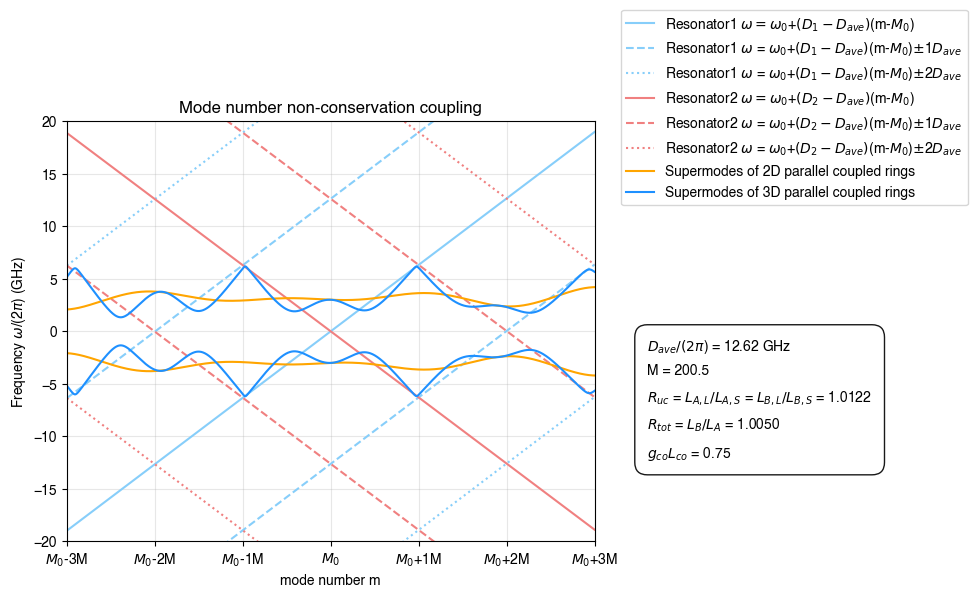

In [20]:
Y_p_2D      = Reson_freq_2D(m_arr_intp, D_ave, g_arr_intp, 2*Lco, epsilon)
Y_m_2D      = -Reson_freq_2D(m_arr_intp, D_ave, g_arr_intp, 2*Lco, epsilon)
Y_3D_ana_p  = Reson_freq_3D(m_arr_intp,D_ave,g_arr_intp,Lco,LAS,LAL,LBS,LBL)
Y_3D_ana_m  = -Reson_freq_3D(m_arr_intp,D_ave,g_arr_intp,Lco,LAS,LAL,LBS,LBL)
Y_3D_nume  = Reson_freq_3D_numerical(m_arr_intp,D_ave,g_arr_intp,Lco,LAS,LAL,LBS,LBL)
data_arr = np.c_[Y_p_2D,Y_m_2D,Y_3D_ana_p,Y_3D_ana_m]
data_label_arr = ["","Supermodes of 2D parallel coupled rings",
                  "","Supermodes of 3D parallel coupled rings",
                  "3D numerical ?"]*3
text = r"$D_{ave}/(2\pi$) = "+"{:.2f} GHz".format(D_ave/(2*np.pi)*1e-9)+"\n"\
        "M = "+"{:.1f}".format(M)+"\n"\
        r"$R_{uc}$ = $L_{A,L}/L_{A,S}$ = $L_{B,L}/L_{B,S}$"+ " = {:.4f}".format(Ruc)+"\n"\
        r"$R_{tot}$ = $L_B/L_A$"+ " = {:.4f}".format(Rtot)+"\n"+\
        r"$g_{co}L_{co}$"+" = {:.2f}".format(g0*Lco)

param_dict  = {"alpha_list": [1]*14+[0.6,0.6]+[1]*4,
               "text":text,
               "loc_text":(1.1,0.2),
               "linespacing":1.8}
Mode_nonconserved_coupling(Max_M_idx,M,plot_coupled_curves=True,
                           coupled_data_arr=data_arr,
                           coupled_data_label_arr=data_label_arr,
                           param_dict_ = param_dict,
                           num_of_pts=num_of_pts,ylim=(-20,20))

In [21]:
# Dispersion of isolated resonator
D_iso   = -668                                # unit: ps/nm/km
n_g     = 1.59367
beta_2  = -1550**2/(2*np.pi*c) * D_iso *1e-9  # unit: ps^2/nm
D_2     = -c* (D_ave*1e-12)**2* beta_2 / n_g  # unit: 2pi * GHz
D_2o    = D_2*1e9                             # unit: Hz
D_2o    = -284 *1e3 * 2*np.pi
D_2o

-1784424.6272390024

In [22]:
D_iso       = D_2o * np.ones((np.shape(m_arr_intp)[0]-4,))
D_2D        = Dispersion_2D(m_arr_intp,D_ave, g_arr_intp, 2*Lco,epsilon)[2:-2]
D_2D_num    = Dispersion_2D_num(m_arr_intp,Y_p_2D)
D_3D        = Dispersion_3D(m_arr_intp,Y_3D_ana_p)
# FSR_3D      = FSR_func_3D(m_arr_intp,Y_3D[:,1])
np.shape(D_2D_num)
np.shape(D_3D)

(9996,)

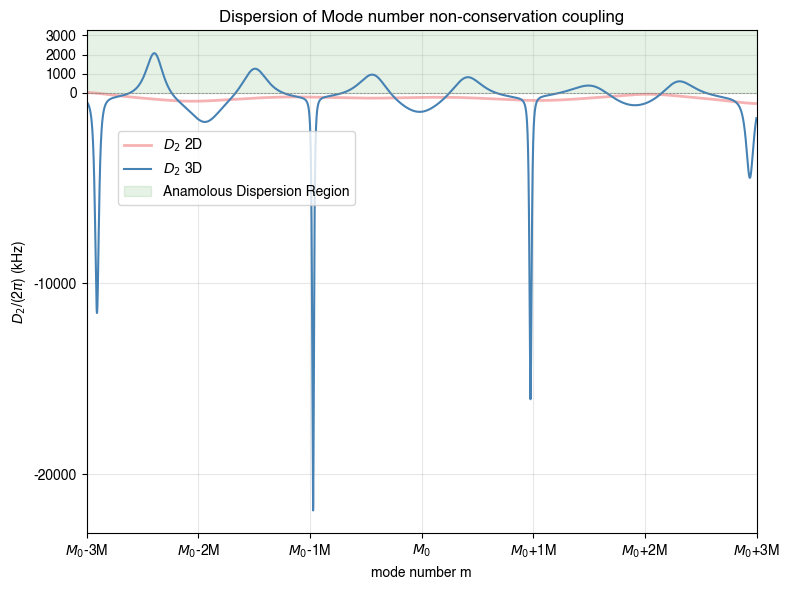

In [23]:
data_arr        = np.c_[D_2D+D_iso,D_3D+D_iso]
data_arr        = (np.c_[m_arr_intp[2:-2] ,data_arr/1e3/(2*np.pi)],)
# data_arr        = np.c_[FSR_3D]
# data_arr        = (np.c_[m_arr_intp[1:-1] ,data_arr/1e3/(2*np.pi)],)

data_label_arr  = [r"$D_2$ 2D", r"$D_2$ 3D",[r"$D_2$ 2D num"]]*3
color_list      = ['lightcoral']+['steelblue']+['tab:blue']+['tab:green']*2+['black']*10
linestyle_list  = ["-"]*10

xticks       = np.arange(-Max_M_idx,Max_M_idx+1)
xtickslabels = [("$M_0$+" if xtick>0 else "$M_0$") + str(xtick) + "M"
                for xtick in xticks]
xtickslabels[int(len(xtickslabels)/2)] = "$M_0$"
xticks       = np.arange(-Max_M_idx,Max_M_idx+1)*M
yticks       = ticks_arr(data_arr)
param_dict   = {"Y_legends"     : data_label_arr,
                "X_label"       :'mode number m',
                "Y_label"       : r"$D_2$/(2$\pi$) (kHz)",
                "title"         : "Dispersion of Mode number non-conservation coupling",
                "figsize"       : (8,6),
                "plot_linewidth": [2,1.5],
                "marker_list"   : [""]*15,
                "linestyle_list": linestyle_list,
                "colors_list"   : color_list,
                "alpha_list"    : [0.6,1],
                "xticks"        : xticks,
                "xtickslabel"   : xtickslabels,
                "yticks"        : yticks,
                "xlim"          : (-Max_M_idx*M,(Max_M_idx)*M),
                # "ylim"          : (-10000,9000),
                "AD_region_color"    : True,
                "bbox_legend"   :(0.4,0.8)}
Plot_curve(data_arr,**param_dict)



In [27]:
TOD_3D_arr      = TOD_3D(m_arr_intp,Y_3D_ana_p)
np.shape(TOD_3D_arr)


(9994,)

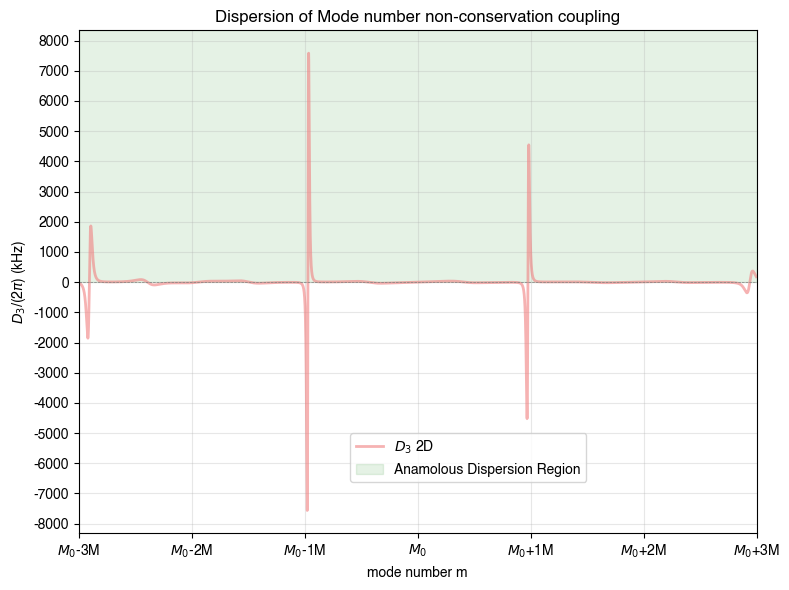

In [28]:
data_arr        = np.c_[TOD_3D_arr]
data_arr        = (np.c_[m_arr_intp[3:-3] ,data_arr/1e3/(2*np.pi)],)
# data_arr        = np.c_[FSR_3D]
# data_arr        = (np.c_[m_arr_intp[1:-1] ,data_arr/1e3/(2*np.pi)],)

data_label_arr  = [r"$D_3$ 2D", r"$D_2$ 3D",[r"$D_2$ 2D num"]]*3
color_list      = ['lightcoral']+['steelblue']+['tab:blue']+['tab:green']*2+['black']*10
linestyle_list  = ["-"]*10

xticks       = np.arange(-Max_M_idx,Max_M_idx+1)
xtickslabels = [("$M_0$+" if xtick>0 else "$M_0$") + str(xtick) + "M"
                for xtick in xticks]
xtickslabels[int(len(xtickslabels)/2)] = "$M_0$"
xticks       = np.arange(-Max_M_idx,Max_M_idx+1)*M
yticks       = ticks_arr(data_arr)
param_dict   = {"Y_legends"     : data_label_arr,
                "X_label"       :'mode number m',
                "Y_label"       : r"$D_3$/(2$\pi$) (kHz)",
                "title"         : "Dispersion of Mode number non-conservation coupling",
                "figsize"       : (8,6),
                "plot_linewidth": [2,1.5],
                "marker_list"   : [""]*15,
                "linestyle_list": linestyle_list,
                "colors_list"   : color_list,
                "alpha_list"    : [0.6,1],
                "xticks"        : xticks,
                "xtickslabel"   : xtickslabels,
                "yticks"        : yticks,
                "xlim"          : (-Max_M_idx*M,(Max_M_idx)*M),
                # "ylim"          : (-10000,9000),
                "AD_region_color"    : True,
                "bbox_legend"   :(0.4,0.2)}
Plot_curve(data_arr,**param_dict)



In [29]:
np.linspace(0.05,0.9,18)

array([0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 , 0.55,
       0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 ])

In [30]:
# gL_arr = np.linspace(0.05,0.9,18)
# for gL in gL_arr:
#     Lco = gL / g0

#     L1      = (Lco + LAS + LAL)*2
#     L2      = (Lco + LBS + LBL)*2
#     D1      = c/(ng_1550 * L1) *2* np.pi
#     D2      = c/(ng_1550 * L2) *2* np.pi
#     D_ave   = c/(ng_1550 * (L1+L2)/2) *2 *np.pi
#     epsilon = (L2-L1)/(L1+L2)
#     FSR     = (D1-D2)/(2*epsilon)
#     M       = 1/(2*epsilon)

#     m_arr_intp      = np.linspace(-Max_M_idx*M, Max_M_idx*M, num_of_pts)
#     freq_arr_intp   = freq_1550 + m_arr_intp * D_ave/(2*np.pi)

#     # Reson Freq
#     Y_p_2D      = Reson_freq_2D(m_arr_intp,D_ave,g_arr_intp,2*Lco,epsilon)
#     Y_m_2D      = -Reson_freq_2D(m_arr_intp,D_ave,g_arr_intp,2*Lco,epsilon)

#     Y_3D_ana_p  = Reson_freq_3D(m_arr_intp,D_ave,g_arr_intp,Lco,LAS,LAL,LBS,LBL)
#     Y_3D_ana_m  = -Reson_freq_3D(m_arr_intp,D_ave,g_arr_intp,Lco,LAS,LAL,LBS,LBL)
#     Y_3D_nume  = Reson_freq_3D_numerical(m_arr_intp,D_ave,g_arr_intp,Lco,LAS,LAL,LBS,LBL)
#     data_arr = np.c_[Y_p_2D,Y_m_2D,Y_3D_ana_p,Y_3D_ana_m]

#     data_label_arr = ["","Supermodes of 2D parallel coupled rings",
#                     "","Supermodes of 3D parallel coupled rings",
#                     "","3D theory ?"]*3

#     param_dict  = { "alpha_list" : [1]*14+[0.6,0.6]+[1]*4,
#                     "foldername"  : "../data/scan_gL/"}
#     Mode_nonconserved_coupling(Max_M_idx,M,plot_coupled_curves=True,
#                             coupled_data_arr=data_arr,
#                             coupled_data_label_arr=data_label_arr,
#                             param_dict_ = param_dict,
#                             title ="Mode number non-conservation coupling, gL={:.2f}".format(gL),
#                             num_of_pts=num_of_pts,ylim=(-20,20))

#     # Dispersion
#     D_iso       = D_2o * np.ones((np.shape(m_arr_intp)[0]-4,))
#     D_2D        = Dispersion_2D(m_arr_intp,D_ave,g_arr_intp,2*Lco,epsilon)[2:-2]
#     D_3D        = Dispersion_3D(m_arr_intp,Y_3D_ana_p)

#     data_arr        = np.c_[D_2D+D_iso,D_3D+D_iso]
#     data_arr        = (np.c_[m_arr_intp[2:-2] ,data_arr/1e3/(2*np.pi)],)

#     data_label_arr  = [r"$D_2$ 2D", r"$D_2$ 3D"]*3
#     color_list      = ['lightcoral']+['steelblue']+['tab:blue']+['tab:green']*2+['black']*10
#     linestyle_list  = ["-"]*10

#     xticks       = np.arange(-Max_M_idx,Max_M_idx+1)
#     xtickslabels = [("$M_0$+" if xtick>0 else "$M_0$") + str(xtick) + "M"
#                     for xtick in xticks]
#     xtickslabels[int(len(xtickslabels)/2)] = "$M_0$"
#     xticks       = np.arange(-Max_M_idx,Max_M_idx+1)*M
#     yticks       = ticks_arr(data_arr)
#     param_dict   = {"Y_legends"     : data_label_arr,
#                     "X_label"       :'mode number m',
#                     "Y_label"       : r"$D_2$/(2$\pi$) (kHz)",
#                     "title"         : "Dispersion of Mode number non-conservation coupling, gL={:.2f}".format(gL),
#                     "figsize"       : (8,6),
#                     "plot_linewidth": [1.5,1.5]*3,
#                     "marker_list"   : [""]*15,
#                     "linestyle_list": linestyle_list,
#                     "colors_list"   : color_list,
#                     "alpha_list"    : [0.6,1],
#                     "xticks"        : xticks,
#                     "xtickslabel"   : xtickslabels,
#                     "yticks"        : yticks,
#                     # "xlim"          : (-Max_M_idx*M,(Max_M_idx)*M),
#                     "ylim"          : (-2000,3000),
#                     "AD_region_color"    : True,
#                     # "bbox_legend"   :(0.4,0.2),
#                     "foldername"    : "../data/scan_gL_Duc2>0, LBS>LAL Luc=1_001/",
#                     # "foldername"    : "../data/scan_gL/"
#                     }
#     Plot_curve(data_arr,**param_dict)




In [31]:
# # ratio_tot_arr = np.linspace(1.0001,1.0091,10)
# ratio_tot_arr = np.linspace(1.003,1.003,1)
# ratio_uc_arr  = np.linspace(1.000,1.030,16)
# # D = np.array([[1.0041,1.0056],
# #                 [1.0041,1.0071],
# #                 [1.0051,1.0041],
# #                 [1.0051,1.0056],
# #                 [1.0051,1.0071],
# #                 [1.0061,1.0056],
# #                 [1.0061,1.0071],
# #                 [1.0071,1.0071],
# #                 [1.0081,1.0071]])

# # unit: m
# g0  = 694
# LAS = 1.6 * 1e-3
# Lco = 0.5 / g0

# for ratio_tot in ratio_tot_arr:
#     for ratio_uc in ratio_uc_arr:

#         LAL = LAS     *ratio_uc
#         LBS = LAS     *ratio_tot
#         LBL = LAS     *ratio_tot  * ratio_uc

#         L1      = (Lco + LAS + LAL)*2
#         L2      = (Lco + LBS + LBL)*2
#         D1      = c/(ng_1550 * L1) *2* np.pi
#         D2      = c/(ng_1550 * L2) *2* np.pi
#         D_ave   = c/(ng_1550 * (L1+L2)/2) *2 *np.pi
#         epsilon = (L2-L1)/(L1+L2)
#         FSR     = (D1-D2)/(2*epsilon)
#         M       = 1/(2*epsilon)
#         # print("epsilon = ",epsilon)

#         m_arr_intp      = np.linspace(-Max_M_idx*M, Max_M_idx*M, num_of_pts)

#         Y_p_2D      = Reson_freq_2D(m_arr_intp,D_ave,g_arr_intp,2*Lco,epsilon)
#         Y_m_2D      = -Reson_freq_2D(m_arr_intp,D_ave,g_arr_intp,2*Lco,epsilon)
#         Y_p_3D      = Reson_freq_3D(m_arr_intp,D_ave,g_arr_intp,Lco,LAS,LAL,LBS,LBL)

#         data_arr = np.c_[Y_p_2D,Y_m_2D,Y_p_3D]
#         data_label_arr = ["","Supermodes of 2D parallel coupled rings",
#                         "","Supermodes of 3D parallel coupled rings",
#                         "","3D theory ?"]*3

#         Mode_nonconserved_coupling(Max_M_idx,M,plot_coupled_curves=True,
#                                 coupled_data_arr=data_arr,
#                                 coupled_data_label_arr=data_label_arr,
#                                 title ="Reson frequency of Mode number non-conservation coupling "+\
#                                             r"epsilon={:.6f},".format(epsilon)+\
#                                             r"$ratio_{uc}$"+"={:.6f}".format(ratio_uc),
#                                 num_of_pts=num_of_pts,ylim=(-20,20))

#         D_iso       = D_2o * np.ones((np.shape(m_arr_intp)[0]-4,))
#         D_2D        = Dispersion_2D(m_arr_intp,D_ave,g_arr_intp,2*Lco,epsilon)[2:-2]
#         D_3D        = Dispersion_3D(m_arr_intp,Y_p_3D)

#         data_arr        = np.c_[D_2D+D_iso,D_3D+D_iso]
#         data_arr        = (np.c_[m_arr_intp[2:-2] ,data_arr/1e3/(2*np.pi)],)

#         data_label_arr  = [r"$D_2$ 2D", r"$D_2$ 3D"]*3
#         color_list      = ['indianred']+['Orange']+['tab:blue']+['tab:green']*2+['black']*10
#         linestyle_list  = ["-"]*10

#         xticks       = np.arange(-Max_M_idx,Max_M_idx+1)
#         xtickslabels = [("$M_0$+" if xtick>0 else "$M_0$") + str(xtick) + "M"
#                         for xtick in xticks]
#         xtickslabels[int(len(xtickslabels)/2)] = "$M_0$"
#         xticks       = np.arange(-Max_M_idx,Max_M_idx+1)*M
#         yticks       = ticks_arr(data_arr)
#         param_dict   = {"Y_legends"     : data_label_arr,
#                         "X_label"       :'mode number m',
#                         "Y_label"       : r"$D_2$/(2$\pi$) (kHz)",
#                         "title"         : "Dispersion of Mode number non-conservation coupling "+\
#                                             r"epsilon={:.6f},".format(epsilon)+\
#                                             r"$ratio_{uc}$"+"={:.6f}".format(ratio_uc),
#                         "figsize"       : (8,6),
#                         "marker_list"   : [""]*15,
#                         "linestyle_list": linestyle_list,
#                         "colors_list"   : color_list,
#                         "xticks"        : xticks,
#                         "xtickslabel"   : xtickslabels,
#                         # "yticks"        : yticks,
#                         # "xlim"          : (-Max_M_idx*M,(Max_M_idx)*M),
#                         "ylim"          : (-5000,5000),
#                         "AD_region_color"    : True,
#                         "bbox_legend"   :(0.4,0.2),
#                         "foldername"    : "../data/scan_len/"
# }
#         Plot_curve(data_arr,**param_dict)



In [32]:
# Max_M_idx = 2
# # ratio_tot_arr = np.linspace(1.0001,1.0091,10)
# ratio_uc_arr  = np.linspace(1.0054,1.0054,1)
# gL_arr = np.linspace(0.8,1.8,11)

# # unit: m
# g0  = 673
# LAS = 3.14  * 1e-3  # unit: m
# Lco = 1.5   * 1e-3

# Rtot= 1.001

# for Ruc in ratio_uc_arr:
#     for gL in gL_arr:

#         g_arr_eff   = g_arr_intp * gL /(g0*Lco)
#         LAL         = LAS   * Ruc
#         LBS         = LAS   * Rtot + Lco * (Rtot-1) / (1+Ruc)
#         LBL         = LBS   * Ruc

#         L1      = (Lco + LAS + LAL)*2
#         L2      = (Lco + LBS + LBL)*2
#         D1      = c/(ng_1550 * L1) *2* np.pi
#         D2      = c/(ng_1550 * L2) *2* np.pi
#         D_ave   = c/(ng_1550 * (L1+L2)/2) *2 *np.pi
#         epsilon = (L2-L1)/(L1+L2)
#         FSR     = (D1-D2)/(2*epsilon)
#         M       = 1/(2*epsilon)
#         print("M = ",M)

#         m_arr_intp  = np.linspace(-Max_M_idx*M, Max_M_idx*M, num_of_pts)

#         Y_p_2D      = Reson_freq_2D(m_arr_intp,D_ave,g_arr_eff,2*Lco,epsilon)
#         Y_m_2D      = -Reson_freq_2D(m_arr_intp,D_ave,g_arr_eff,2*Lco,epsilon)
#         Y_p_3D      = Reson_freq_3D(m_arr_intp,D_ave,g_arr_eff,Lco,LAS,LAL,LBS,LBL)
#         Y_m_3D      = -Reson_freq_3D(m_arr_intp,D_ave,g_arr_eff,Lco,LAS,LAL,LBS,LBL)

#         data_arr = np.c_[Y_p_2D,Y_m_2D,Y_p_3D]
#         data_label_arr = ["","Supermodes of 2D parallel coupled rings",
#                         "","Supermodes of 3D parallel coupled rings",
#                         "","3D theory ?"]*3
#         Mode_nonconserved_coupling(Max_M_idx,M,plot_coupled_curves=True,
#                                 coupled_data_arr=data_arr,
#                                 coupled_data_label_arr=data_label_arr,
#                                 title ="Reson frequency of Mode number non-conservation coupling "+\
#                                             r"$R_{uc}$"+"={:.6f},".format(Ruc)+\
#                                             r"$gL$"+"={:.6f}".format(gL),
#                                 num_of_pts=num_of_pts,ylim=(-20,20))

#         D_iso       = D_2o * np.ones((np.shape(m_arr_intp)[0]-4,))
#         D_2D        = Dispersion_2D(m_arr_intp,D_ave,g_arr_eff,2*Lco,epsilon)[2:-2]
#         D_3D        = Dispersion_3D(m_arr_intp,Y_m_3D)

#         data_arr        = np.c_[D_2D+D_iso,D_3D+D_iso]
#         data_arr        = (np.c_[m_arr_intp[2:-2] ,data_arr/1e3/(2*np.pi)],)

#         data_label_arr  = [r"$D_2$ 2D", r"$D_2$ 3D"]*3
#         color_list      = ['indianred']+['Orange']+['tab:blue']+['tab:green']*2+['black']*10
#         linestyle_list  = ["-"]*10

#         xticks       = np.arange(-Max_M_idx,Max_M_idx+1)
#         xtickslabels = [("$M_0$+" if xtick>0 else "$M_0$") + str(xtick) + "M"
#                         for xtick in xticks]
#         xtickslabels[int(len(xtickslabels)/2)] = "$M_0$"
#         xticks       = xticks * M

#         # xtickslabels = np.array(["{:.1f}".format(3*1e8 / (freq_1550 + D_ave/(2*np.pi) * xtick) * 1e9) for xtick in xticks])

#         yticks       = ticks_arr(data_arr)
#         param_dict   = {"Y_legends"     : data_label_arr,
#                         "X_label"       :'mode number m',
#                         "Y_label"       : r"$D_2$/(2$\pi$) (kHz)",
#                         "title"         : "Dispersion of Mode number non-conservation coupling "+\
#                                             r"$R_{uc}$"+"={:.6f},".format(Ruc)+\
#                                             r"$gL$"+"={:.6f}".format(gL),
#                         "figsize"       : (8,6),
#                         "marker_list"   : [""]*15,
#                         "linestyle_list": linestyle_list,
#                         "colors_list"   : color_list,
#                         "xticks"        : xticks,
#                         "xtickslabel"   : xtickslabels,
#                         # "yticks"        : yticks,
#                         # "xlim"          : (-Max_M_idx*M,(Max_M_idx)*M),
#                         "ylim"          : (-5000,5000),
#                         "AD_region_color"    : True,
#                         # "bbox_legend"   :(0.4,0.2),
#                         "foldername"    : "../data/scan_len/"
#         }
#         Plot_curve(data_arr,**param_dict)



Set the geometry of the two resonators

In [33]:
Max_M_idx = 2
# ratio_tot_arr = np.linspace(1.0001,1.0091,10)
ratio_uc_arr  = np.linspace(1.001,1.029,29)
gL_arr = np.linspace(0.4,1.4,21)

# unit: m
g0  = 673
LAS = 3.14/2  * 1e-3  # unit: m
Lco = 1.5   * 1e-3

Rtot= 1.003

In [34]:
Max_M_idx = 2
# ratio_tot_arr = np.linspace(1.0001,1.0091,10)
ratio_uc_arr    = np.linspace(1.001,1.03,40)
gL_arr          = np.linspace(0.6,1.6,41)

# unit: m
g0  = 673
LAS = 3.14/2    * 1e-3  # unit: m
Lco = 1.5       * 1e-3

Rtot= 1.01

The optimal AD range if the rings are put in 3D offset structure

In [35]:
AD_range_arr = []
for Ruc in ratio_uc_arr:
    AD_range_arr_given_gL = []
    for gL in gL_arr:
        g_arr_eff   = g_arr_intp * gL /(g0*Lco)
        LAL         = LAS   * Ruc
        LBS         = LAS   * Rtot + Lco * (Rtot-1) / (1+Ruc)
        LBL         = LBS   * Ruc

        L1      = (Lco + LAS + LAL)*2
        L2      = (Lco + LBS + LBL)*2
        D1      = c/(ng_1550 * L1) *2* np.pi
        D2      = c/(ng_1550 * L2) *2* np.pi
        D_ave   = c/(ng_1550 * (L1+L2)/2) *2 *np.pi
        epsilon = (L2-L1)/(L1+L2)
        FSR     = (D1-D2)/(2*epsilon)
        M       = 1/(2*epsilon)
        # print("epsilon = ",epsilon)

        m_arr_intp  = np.linspace(-Max_M_idx*M, Max_M_idx*M, num_of_pts)

        Y_p_2D      = Reson_freq_2D(m_arr_intp,D_ave,g_arr_eff,2*Lco,epsilon)
        Y_m_2D      = -Reson_freq_2D(m_arr_intp,D_ave,g_arr_eff,2*Lco,epsilon)
        Y_p_3D      = Reson_freq_3D(m_arr_intp,D_ave,g_arr_eff,Lco,LAS,LAL,LBS,LBL)
        Y_m_3D      = -Reson_freq_3D(m_arr_intp,D_ave,g_arr_eff,Lco,LAS,LAL,LBS,LBL)

        D_iso       = D_2o * np.ones((np.shape(m_arr_intp)[0]-4,))
        D_2D        = Dispersion_2D(m_arr_intp,D_ave,g_arr_eff,2*Lco,epsilon)[2:-2]
        D_3D        = Dispersion_3D(m_arr_intp,Y_m_3D)
        AD_range_res = AD_range_func(m_arr_intp[2:-2], D_3D+D_iso,
                                    M = M, FSR = D_ave/(2*np.pi))
        AD_range_arr_given_gL.append(AD_range_res)

    AD_range_arr.append(AD_range_arr_given_gL)

AD_range_arr  = np.array(AD_range_arr)

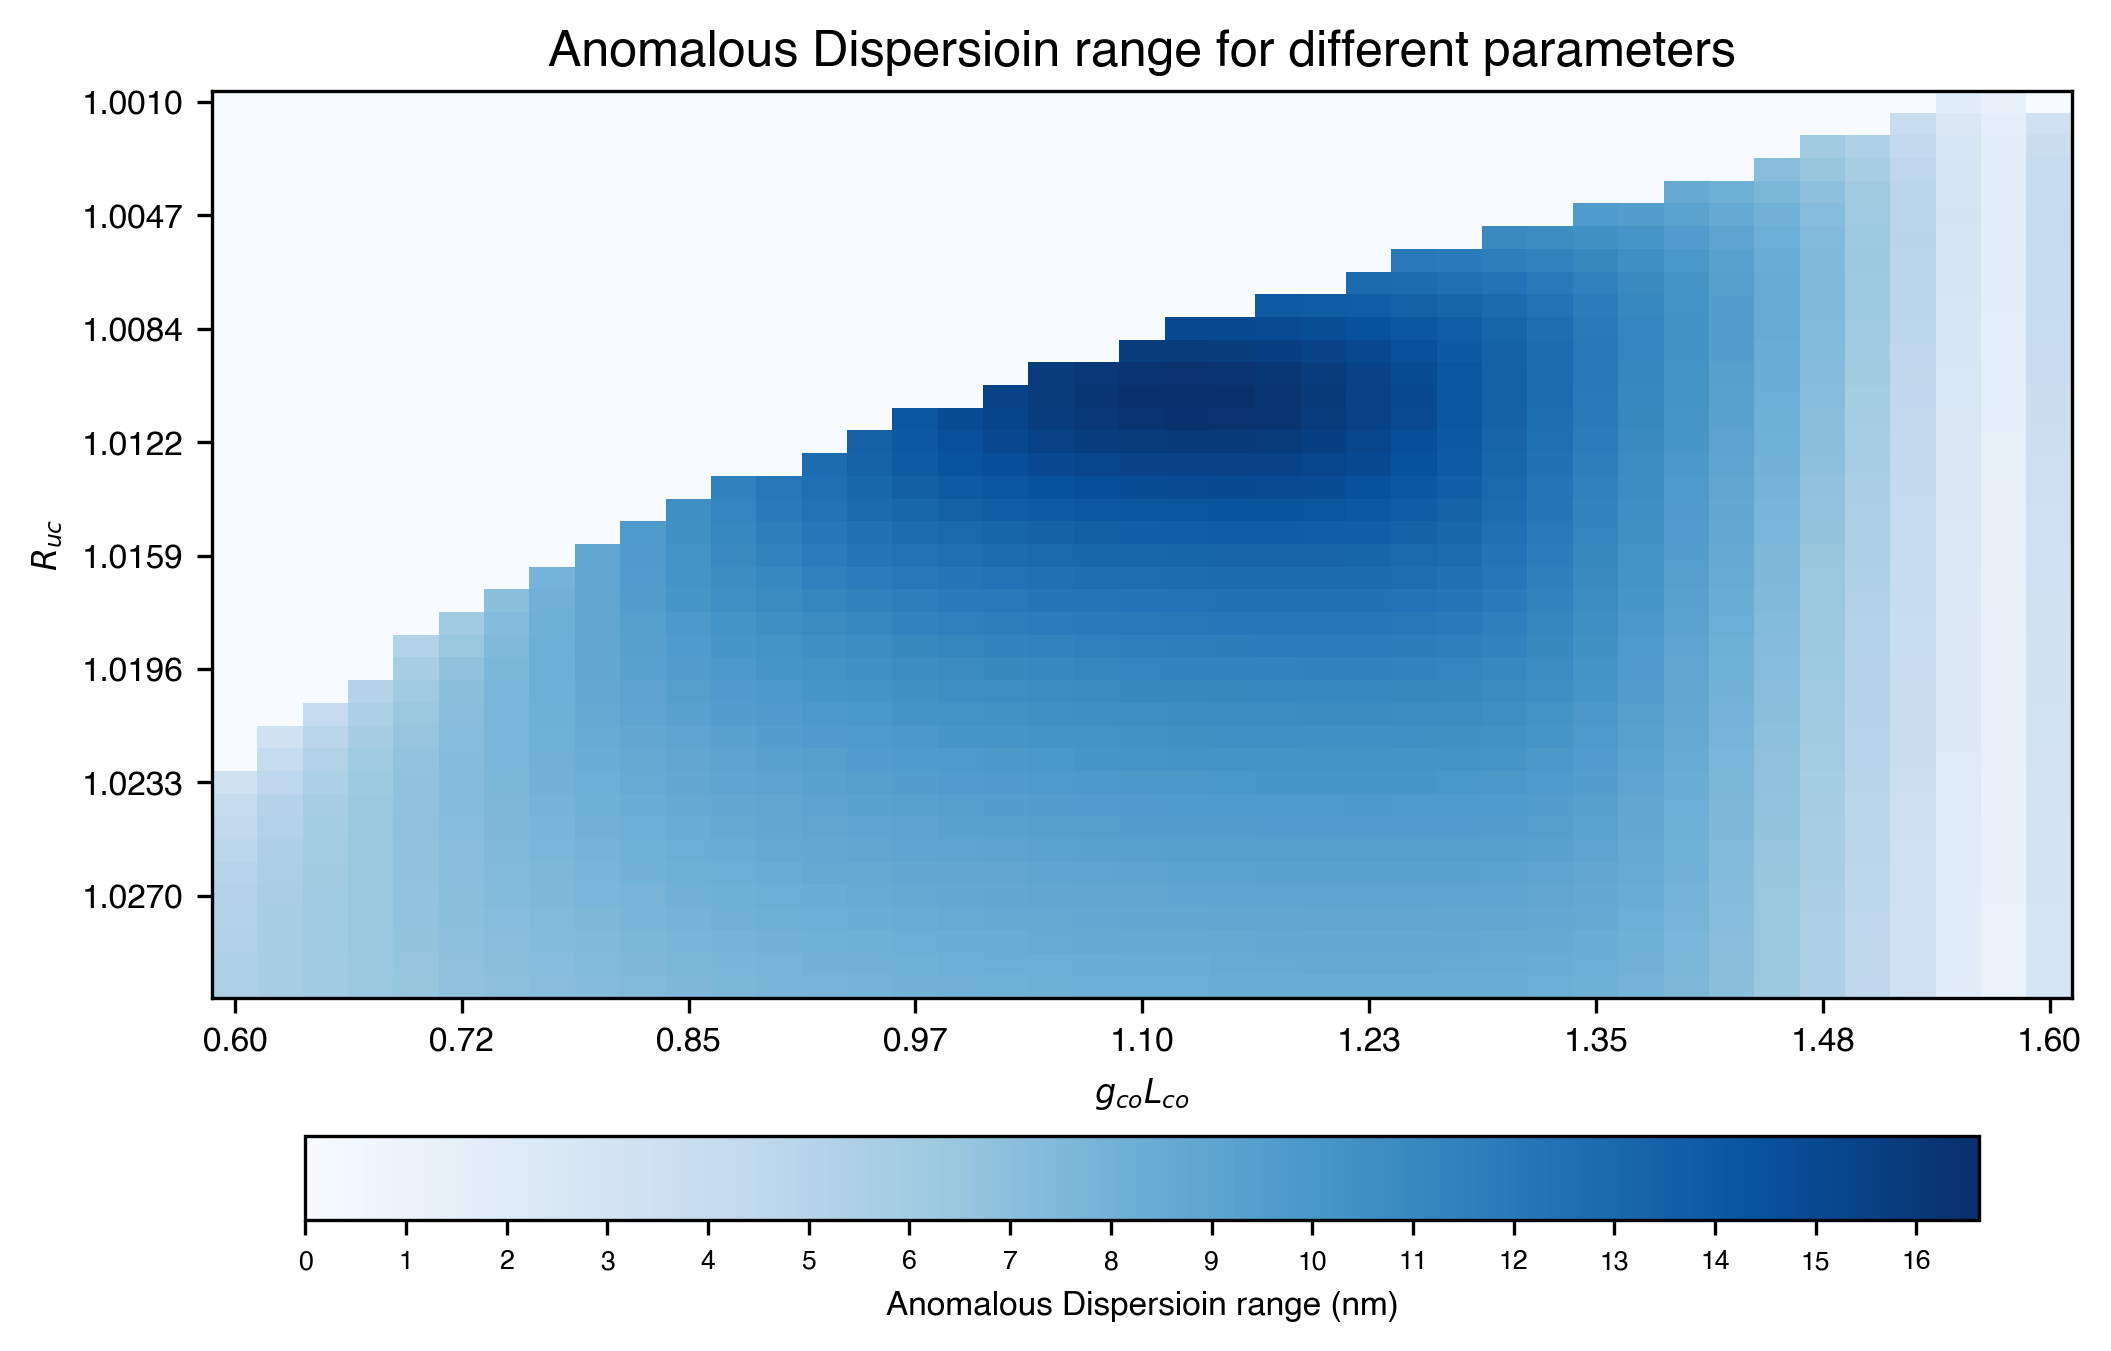

In [36]:
xticks = np.arange(0,len(gL_arr),5)
yticks = np.arange(0,len(ratio_uc_arr),5)

param_dict = {
        "point_color"   : 'yellow',
        "aspect"        : 0.5,
        "xlabel"        : r"$g_{co}L_{co}$",
        "ylabel"        : r"$R_{uc}$",
        "cbar_label"    : "Anomalous Dispersioin range (nm)",
        "cbar_small_ticks" : True,
        "figsize"       : (8,6),
        "title"         : "Anomalous Dispersioin range for different parameters",
        "xticks"        : xticks,
        "yticks"        : yticks,
        "xtickslabel"   : ["{:.2f}".format(gL) for gL in gL_arr[xticks]],
        "ytickslabel"   : ["{:.4f}".format(ep) for ep in ratio_uc_arr[yticks]],
        "fontsize"      : 8,
}
Plot_im(AD_range_arr,**param_dict)

In [37]:
flat_index = np.argmax(AD_range_arr)
max_index = np.unravel_index(flat_index, np.shape(AD_range_arr))
np.array(max_index)

array([13, 21])

In [38]:
# largest AD_range
AD_range_arr[max_index]

np.float64(16.624658980445755)

In [39]:
# best g_co * L_co
best_gL = gL_arr[max_index[1]]
best_gL

np.float64(1.125)

In [40]:
best_Ruc = ratio_uc_arr[max_index[0]]

In [41]:
Max_M_idx = 2
# ratio_tot_arr = np.linspace(1.0001,1.0091,10)
Ruc = best_Ruc
gL = best_gL

g_arr_eff   = g_arr_intp * gL /(g0*Lco)
LAL         = LAS   * Ruc
LBS         = LAS   * Rtot + Lco * (Rtot-1) / (1+Ruc)
LBL         = LBS   * Ruc

L1      = (Lco + LAS + LAL)*2
L2      = (Lco + LBS + LBL)*2
D1      = c/(ng_1550 * L1) *2* np.pi
D2      = c/(ng_1550 * L2) *2* np.pi
D_ave   = c/(ng_1550 * (L1+L2)/2) *2 *np.pi
epsilon = (L2-L1)/(L1+L2)
FSR     = (D1-D2)/(2*epsilon)
M       = 1/(2*epsilon)

In [42]:
print("LAL = {:.3f}mm".format(LAL*1e3))
print("LBS = {:.3f}mm".format(LBS*1e3))
print("L1= {:.3f}mm".format(L1*1e3))
print("L2 = {:.3f}mm".format(L2*1e3))
print("M =", M)
print("D_ave = {:.3f} GHz".format(D_ave/1e9/(2*np.pi)))

LAL = 1.587mm
LBS = 1.593mm
L1= 9.313mm
L2 = 9.407mm
M = 100.4999999999991
D_ave = 20.087 GHz


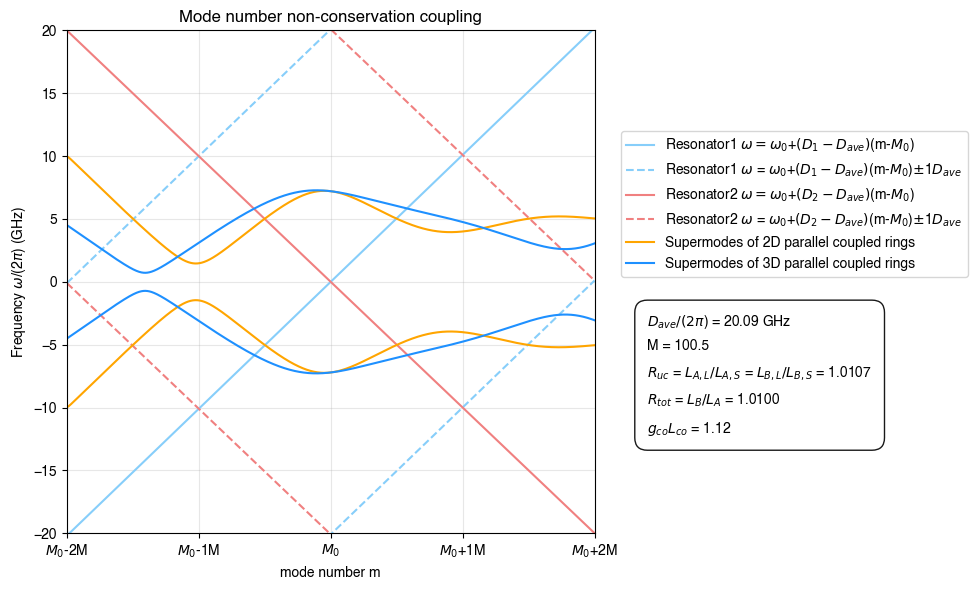

In [43]:
m_arr_intp  = np.linspace(-Max_M_idx*M, Max_M_idx*M, num_of_pts)

Y_p_2D      = Reson_freq_2D(m_arr_intp,D_ave,g_arr_eff,2*Lco,epsilon)
Y_m_2D      = -Reson_freq_2D(m_arr_intp,D_ave,g_arr_eff,2*Lco,epsilon)
Y_p_3D      = Reson_freq_3D(m_arr_intp,D_ave,g_arr_eff,Lco,LAS,LAL,LBS,LBL)
Y_m_3D      = -Reson_freq_3D(m_arr_intp,D_ave,g_arr_eff,Lco,LAS,LAL,LBS,LBL)

data_arr = np.c_[Y_p_2D,Y_m_2D,Y_p_3D,Y_m_3D]
data_label_arr = ["","Supermodes of 2D parallel coupled rings",
                  "","Supermodes of 3D parallel coupled rings",
                  "3D numerical ?"]*3
text = r"$D_{ave}/(2\pi$) = "+"{:.2f} GHz".format(D_ave/(2*np.pi)*1e-9)+"\n"\
        "M = "+"{:.1f} ".format(M)+"\n"\
        r"$R_{uc}$ = $L_{A,L}/L_{A,S}$ = $L_{B,L}/L_{B,S}$"+ " = {:.4f}".format(best_Ruc)+"\n"\
        r"$R_{tot}$ = $L_B/L_A$"+ " = {:.4f}".format(Rtot)+"\n"+\
        r"$g_{co}L_{co}$"+" = {:.2f}".format(best_gL)
param_dict  = {"alpha_list": [1]*14+[0.6,0.6]+[1]*4,
               "text":text,
               "loc_text":(1.1,0.2),
               "linespacing":1.8}
Mode_nonconserved_coupling(Max_M_idx,M,plot_coupled_curves=True,
                           coupled_data_arr=data_arr,
                           coupled_data_label_arr=data_label_arr,
                           param_dict_ = param_dict,
                           num_of_pts=num_of_pts,ylim=(-20,20))

The optimal AD range if the same rings are put in 2D parallel structure

In [44]:
gL_product_arr  = np.arange(0.1,1.6,0.1)
L2_ratio_arr    = np.linspace(L2/L1, L2/L1 ,1)
epsilon_arr     = epsilon_func(L1, L1*L2_ratio_arr)
Lco_arr         = gL_product_arr  / g0
AD_range_2D_arr    = []
for L2_ratio in L2_ratio_arr:
    L2      = L1 * L2_ratio
    D1      = c/(ng_1550 * L1) *2* np.pi
    D2      = c/(ng_1550 * L2) *2* np.pi
    D_ave   = c/(ng_1550 * (L1+L2)/2) *2 *np.pi
    # D_ave = D1 * 0.99
    epsilon = (L2-L1)/(L1+L2)
    FSR = (D1-D2)/(2*epsilon)
    M = 1/(2*epsilon)

    AD_range_2D_arr_given_L2 = []
    for Lco in Lco_arr:
        Reson_freq_arr = Reson_freq_2D(m_arr_intp,D_ave,g_arr_intp,Lco,epsilon)
        D_coupled_arr  = Dispersion_2D_num(m_arr_intp,Reson_freq_arr)
        AD_range_2D_res = AD_range_func(m_arr_intp[2:-2], D_coupled_arr + D_iso,
                                        M = M, FSR = D_ave/(2*np.pi))
        AD_range_2D_arr_given_L2.append(AD_range_2D_res)

    AD_range_2D_arr.append(AD_range_2D_arr_given_L2)

AD_range_2D_arr    = np.array(AD_range_2D_arr)

In [48]:
flat_index = np.argmax(AD_range_2D_arr)
max_index_2D = np.unravel_index(flat_index, np.shape(AD_range_2D_arr))
best_AD_range_2D = AD_range_2D_arr[max_index_2D]
best_gL_2D = gL_product_arr[max_index_2D[1]]
best_gL_2D

np.float64(0.9)

Draw and compare 2D and 3D structures

In [49]:
D_iso       = D_2o * np.ones((np.shape(m_arr_intp)[0]-4,))
D_2D        = Dispersion_2D(m_arr_intp,D_ave,g_arr_intp,best_gL_2D/g0,epsilon)[2:-2]
D_3D        = Dispersion_3D(m_arr_intp,Y_m_3D)

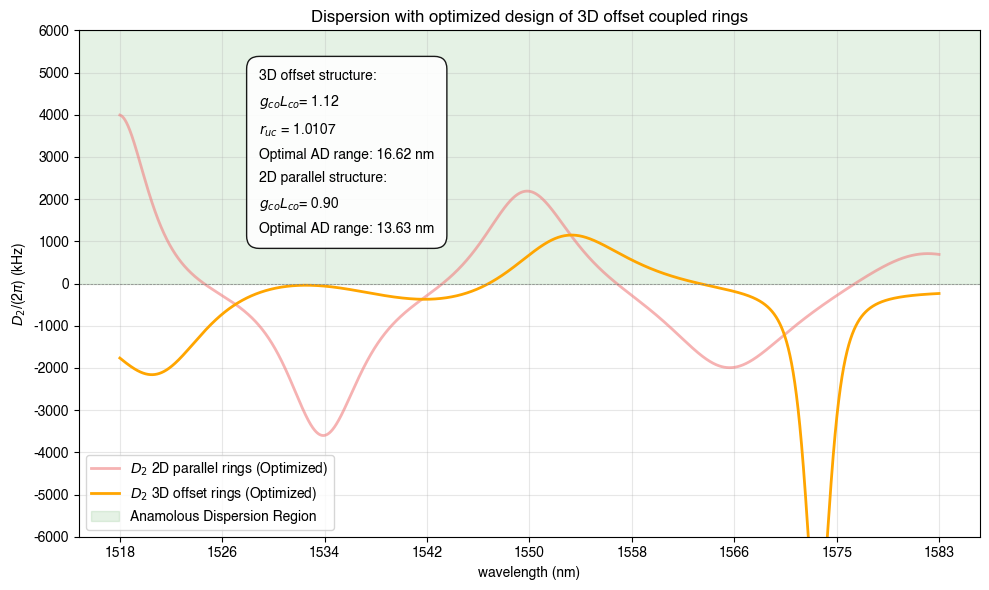

In [50]:
data_arr       = np.flip(np.c_[D_2D+D_iso, D_3D+D_iso],axis=0)
data_label_arr = [r"$D_2$ 2D parallel rings (Optimized)",r"$D_2$ 3D offset rings (Optimized)"]
linestyle_list = ["-"]*10

data_arr     = (np.c_[m_arr_intp[2:-2], data_arr/1e3/(2*np.pi)],)
xticks       = np.arange(-Max_M_idx,Max_M_idx+0.5, 0.5)*M
xtickslabels = np.array(["{:.0f}".format(3*1e8 / (freq_1550 + D_ave/(2*np.pi) * xtick) * 1e9) for xtick in xticks])
yticks       = ticks_arr(data_arr)

text           = "3D offset structure:\n"+ \
                r"$g_{co}L_{co}$"+"= {:.2f}".format(best_gL) +"\n" +\
                r"$r_{uc}$ = "+"{:.4f}".format(best_Ruc) + "\n"+\
                "Optimal AD range: {:.2f} nm".format(AD_range_arr[max_index])+"\n"+\
                "2D parallel structure:\n"+ \
                r"$g_{co}L_{co}$"+"= {:.2f}".format(best_gL_2D) +"\n" +\
                "Optimal AD range: {:.2f} nm".format(best_AD_range_2D)

param_dict = {
    "Y_legends"     : data_label_arr,
    "X_label"       : 'wavelength (nm)',
    "Y_label"       : r"$D_2$/(2$\pi$) (kHz)",
    "title"         : "Dispersion with optimized design of 3D offset coupled rings",
    "figsize"       : (10,6),
    "marker_list"   : [""]*15,
    "linestyle_list": linestyle_list,
    "colors_list"   : ["lightcoral"]+['Orange']+['lightskyblue']+['deepskyblue']+['black']*10,
    "xticks"        : xticks,
    "xtickslabel"   : np.flip(xtickslabels),
    "yticks"        : yticks,
    "alpha_list"    :[0.6,1,1],
    "plot_linewidth": [2,2],
    # "xlim"          : (-3*M,3*M+1),
    # "xlim"          : (-2*M,2*M+1),
    "ylim"          : (-6000,6000),
    "AD_region_color"    : True,
    # "bbox_legend"   : (0.9,0.9),
    "text"          : text,
    # "linespacing"   : 1.5,
    "loc_text"      : (0.2,0.6),
    "linespacing"   : 1.8
}
Plot_curve(data_arr,**param_dict)

In [51]:
def Diff_LAL_LBS(Ruc,Rtot,LAS,Lco):
    LAL         = LAS   * Ruc
    LBS         = LAS   * Rtot + Lco * (Rtot-1) / (1+Ruc)
    return LBS - LAL

Rtot_arr = np.flip(np.linspace(1.0001,1.01,100))
Ruc_arr  = np.linspace(1.0001,1.01,100)
# A,B =   np.meshgrid(Rtot_arr,Ruc_arr)
# L_arr_mesh = np.column_stack((A.ravel(), B.ravel()))
Diff_im_arr = []
for Rtot in Rtot_arr:
    Diff_fixed_Rtot = []
    for Ruc in Ruc_arr:
        Diff_fixed_Rtot.append(Diff_LAL_LBS(Ruc,Rtot,LAS = LAS, Lco = Lco))
    Diff_im_arr.append(Diff_fixed_Rtot)
Diff_im_arr = np.array(Diff_im_arr)

In [52]:
Diff_im_arr_zero_loc_list = []
for i in range(np.shape(Diff_im_arr)[0]):
    line = Diff_im_arr[i,:]

    for j in range(len(line)-1):
        if line[j] * line[j+1] < 0:
            shift = np.abs(line[j])/(np.abs(line[j])+np.abs(line[j+1]))
            Diff_im_arr_zero_loc_list.append([j+shift,i,Ruc_arr[i],Rtot_arr[j]])

# Diff_im_arr_neg_mask = np.where(Diff_im_arr<0)
# Diff_im_arr[Diff_im_arr_neg_mask] = -np.log10(-Diff_im_arr[Diff_im_arr_neg_mask])
# Diff_im_arr_neg_mask = np.where(Diff_im_arr>0)
# Diff_im_arr[Diff_im_arr_neg_mask] = np.log10(Diff_im_arr[Diff_im_arr_neg_mask])

Diff_im_arr_zero_loc_list = np.array(Diff_im_arr_zero_loc_list)
Diff_im_arr_zero_loc_list[:5,:]

array([[97.96668342, 42.        ,  1.0043    ,  1.0003    ],
       [96.2637727 , 43.        ,  1.0044    ,  1.0004    ],
       [94.56074308, 44.        ,  1.0045    ,  1.0006    ],
       [92.85759451, 45.        ,  1.0046    ,  1.0008    ],
       [91.15432697, 46.        ,  1.0047    ,  1.0009    ]])

In [53]:
coefficients = np.polyfit(Diff_im_arr_zero_loc_list[:,2], Diff_im_arr_zero_loc_list[:,3], 1)
coefficients
Diff_arr_fit = coefficients[0]*Diff_im_arr_zero_loc_list[:,2]+coefficients[1]


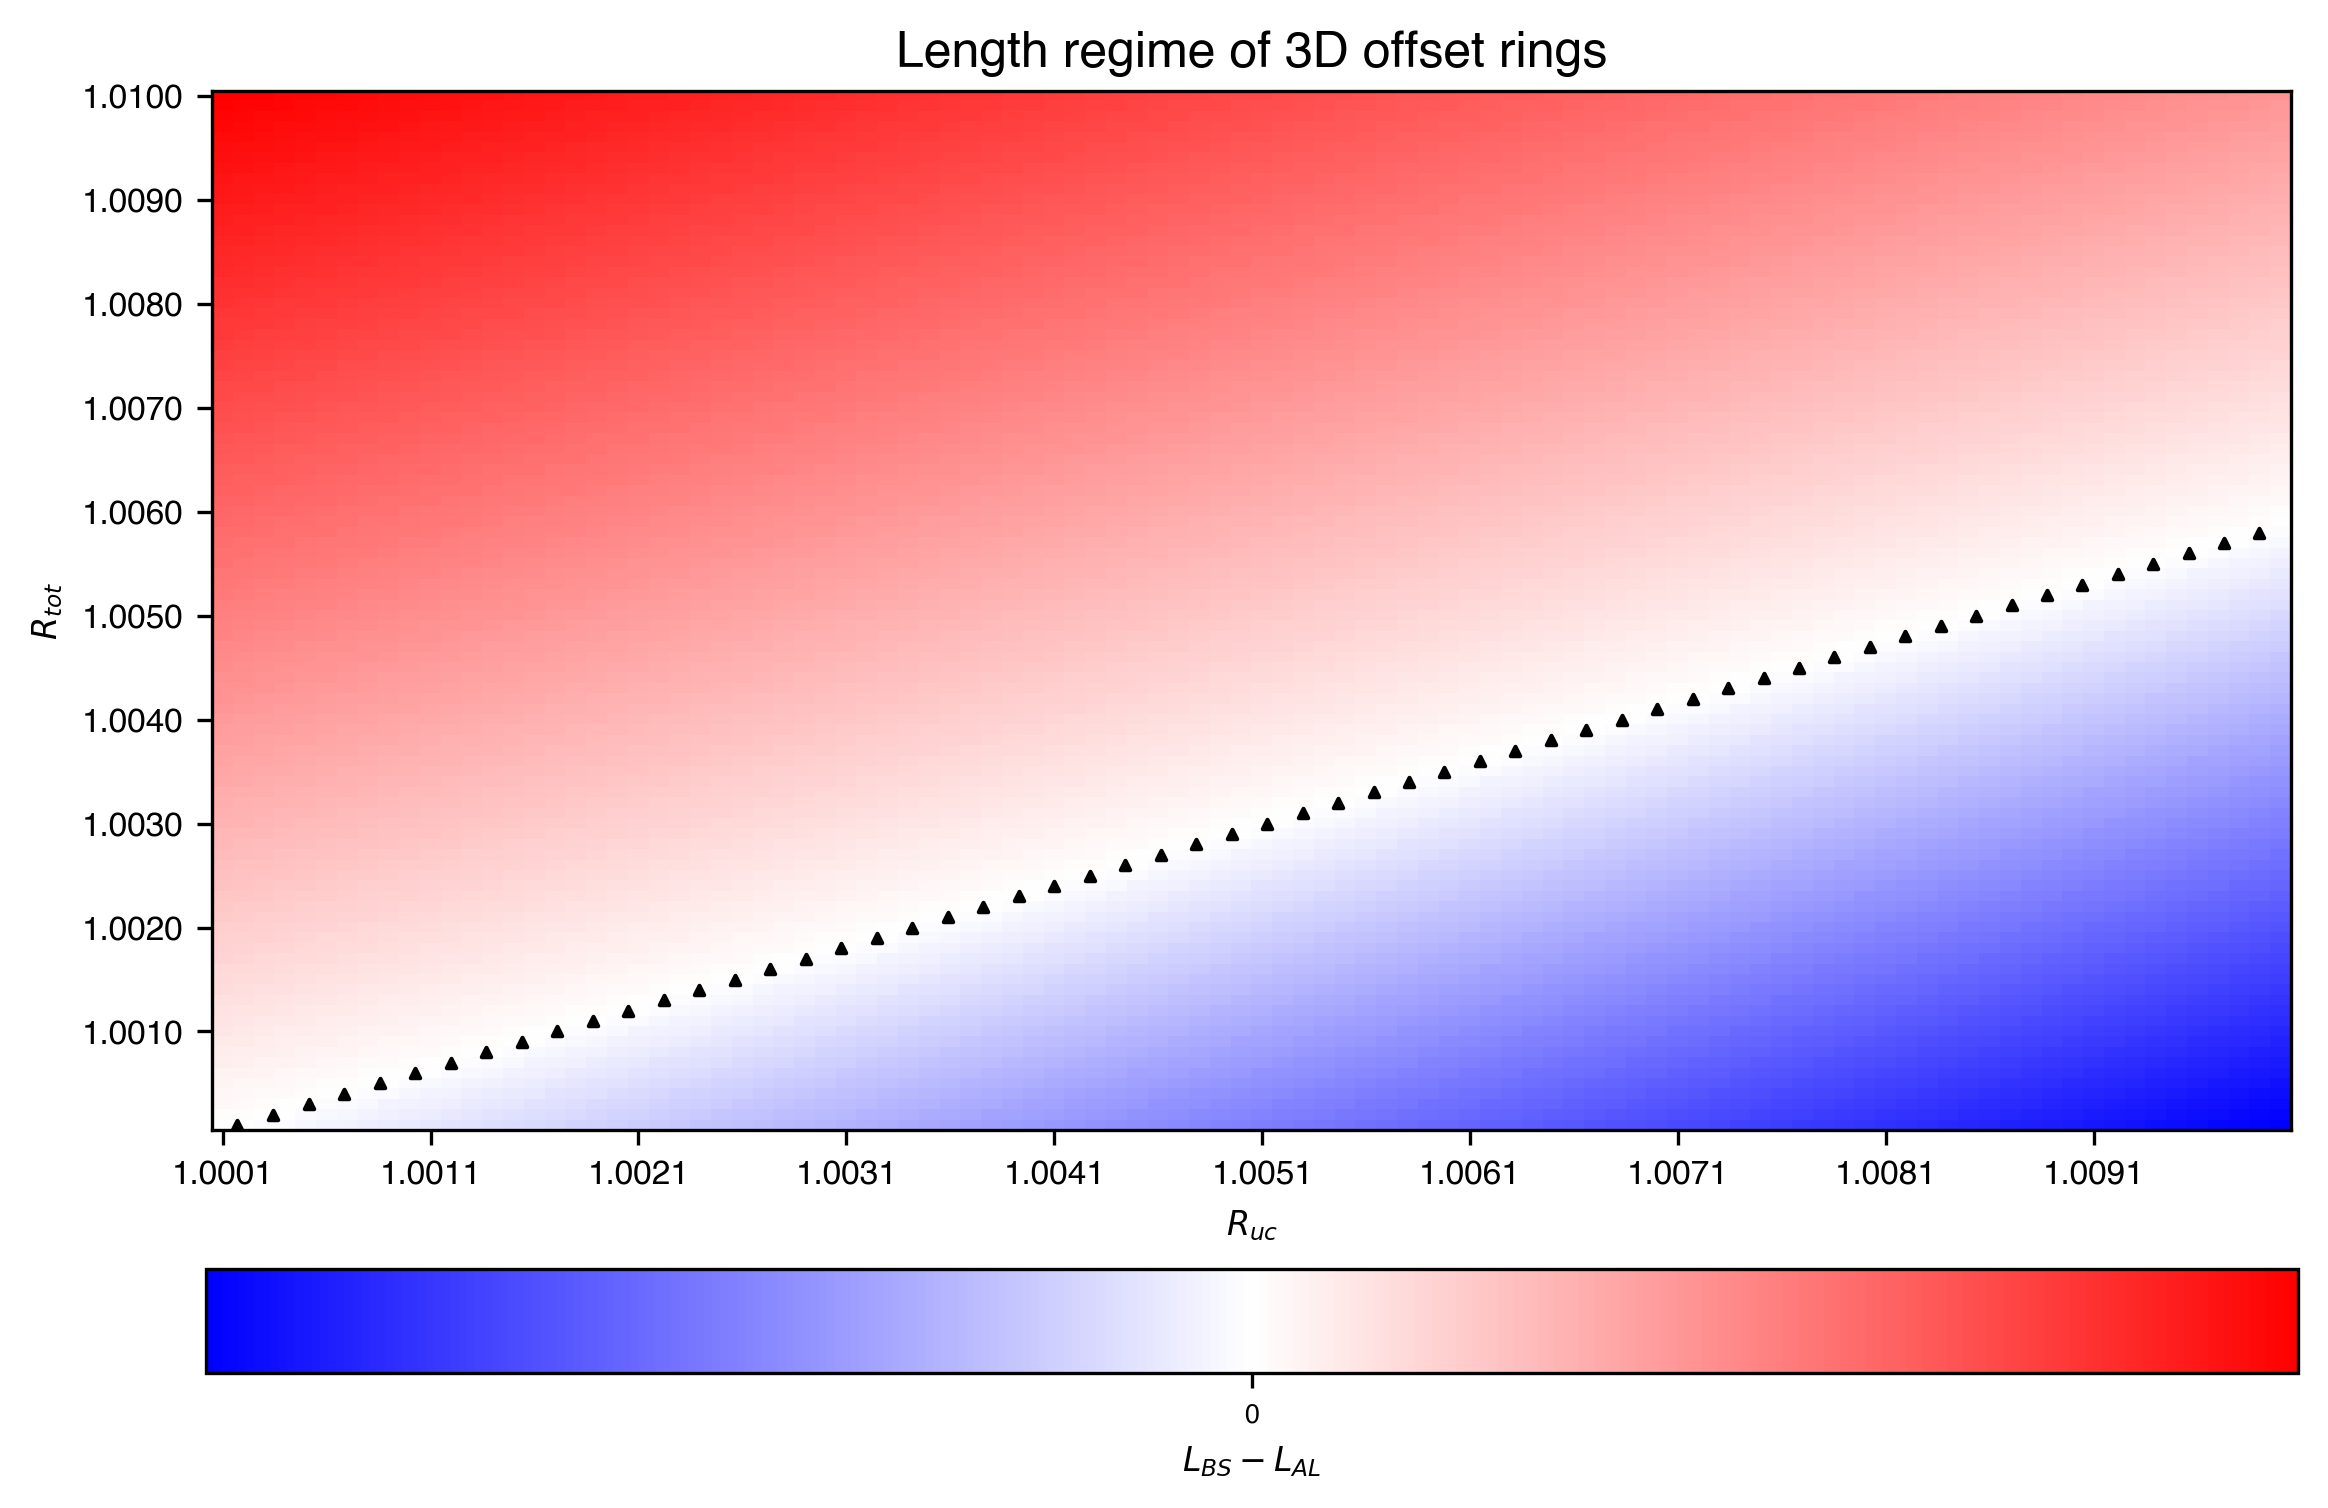

In [54]:
xticks = np.arange(0,len(Ruc_arr),10)
yticks = np.arange(0,len(Rtot_arr),10)

param_dict = {
        "figsize"       : [20,5],
        "point_color"   : 'black',
        "point_size"    : 5,
        "norm"          : 'zero_divided',
        "colormap"      : "bwr",
        "aspect"        : 0.5,
        "xlabel"        : r"$R_{uc}$",
        "ylabel"        : r"$R_{tot}$",
        "cbar_label"    : r"$L_{BS}-L_{AL}$",
        "cbar_small_ticks" : False,
        "figsize"       : (10,6),
        "title"         : "Length regime of 3D offset rings",
        "xticks"        : xticks,
        "yticks"        : yticks,
        "xtickslabel"   : ["{:.4f}".format(Ruc) for Ruc in Ruc_arr[xticks]],
        "ytickslabel"   : ["{:.4f}".format(Rtot) for Rtot in Rtot_arr[yticks]],
        "fontsize"      : 8,
}
Plot_im(Diff_im_arr,point_arr = Diff_im_arr_zero_loc_list, **param_dict)

In [55]:
np.linspace(1.001,1.01,10)

array([1.001, 1.002, 1.003, 1.004, 1.005, 1.006, 1.007, 1.008, 1.009,
       1.01 ])

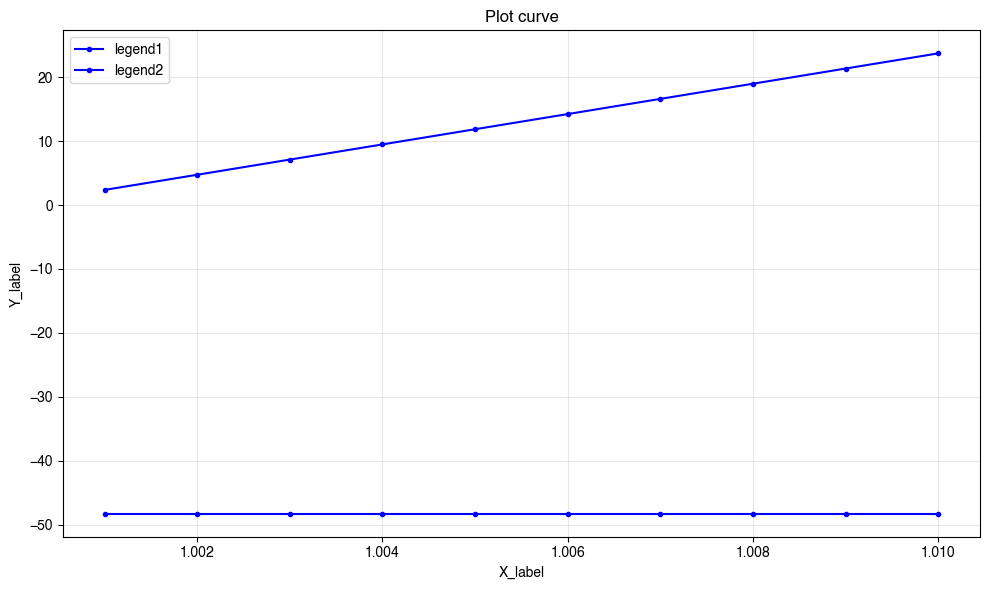

In [59]:
L_bend      = 3.14  *1e-3
L_str_A     = 1.61  *1e-3
Rtot_arr    = np.linspace(1.001,1.01,10)
L_str_B     = (L_bend + L_str_A) * Rtot_arr - L_bend
deltaL_str_arr  = L_str_B - L_str_A
Upper_bound_arr = 0.5 * deltaL_str_arr * 1e6            # unit: um
Lower_bound_arr = -0.03 * L_str_A * np.ones(np.shape(Rtot_arr)) * 1e6     # unit: um

data_arr = (np.c_[Rtot_arr, Upper_bound_arr, Lower_bound_arr],)
Plot_curve(data_arr)